In [115]:
%load_ext autoreload
%autoreload 2

In [117]:

import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import torch
import time

In [118]:
device = torch.device("cpu")

In [119]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [124]:
from utils import ImageDataset, ConvResNet, init_dataloader, channel_binary_mask, \
    checkerboard_binary_mask, AffineCouplingLayer, RealNVP, Scale, FinalScale, FlowBlock, save_plot
import torch
device = torch.device(device)

In [158]:
batch_size = 128
epochs = 100
num_resnet_blocks = 16
num_scales = 2
num_step_of_flow = 2 # 3 * 6 affine layers
sample_path = "./bs_samples"#f"./plots_{num_scales}_scale_{num_step_of_flow * 6}_affines_resnet_{num_resnet_blocks}"

In [6]:
! mkdir -f {sample_path}

mkdir: invalid option -- 'f'
Try 'mkdir --help' for more information.


In [7]:
# celebA_train_dataset = torchvision.datasets.CelebA(root="/home/ext_amin_unity3d_com/real_nvp_data_celebA",
#                                                    split="train",
#                                                    download=True,
#                                                    transform=transforms.Compose([transforms.ToTensor()])
#                                                    )

In [8]:
# celebA_train_dataloader = torch.utils.data.DataLoader(celebA_train_dataset, batch_size=64)

In [9]:
lsun_train_dataset = ImageDataset(root_dir="/home/ext_amin_unity3d_com/real_nvp_data/train")
lsun_train_dataloader = init_dataloader(lsun_train_dataset, batch_size=batch_size)

In [10]:
dataset = lsun_train_dataset
dataloader = lsun_train_dataloader

In [11]:
tmp_input = torch.rand(5, 3, 32, 32).to(device)
tmp_input_split = torch.ones(5, 6, 16, 16).to(device)

In [12]:
scale = Scale(mask_orientation=0).to(device=device)
forwarded_scale, _  = scale(tmp_input)
reversed_scale = scale.reverse(forwarded_scale)
print(torch.norm(tmp_input - reversed_scale))


tensor(577.3474, device='cuda:1')


In [13]:
final_scale = FinalScale().to(device)
forwarded_fs, _ = final_scale(tmp_input_split)
reversed_fs = final_scale.reverse(forwarded_fs)
print(torch.norm(tmp_input_split - reversed_fs))

tensor(0.0028, device='cuda:1')


In [14]:
realnvp = RealNVP(num_scales=num_scales,
                  num_step_of_flow=num_step_of_flow,
                  num_resnet_blocks=num_resnet_blocks).to(device)

In [15]:
z_samples = torch.distributions.Normal(0, 1).sample(sample_shape=([25] + realnvp.final_scale.base_input_shape))
realnvp.sample(z_base_sample=z_samples)

tensor([[[[-6.7813e+05,  8.9277e+07, -9.7800e+06,  ..., -2.0831e+07,
            8.1259e+06, -5.1307e+06],
          [ 1.0568e+08,  2.6953e+08, -1.5340e+08,  ..., -1.3975e+07,
            8.0875e+05, -7.9103e+06],
          [ 1.2972e+08,  4.8134e+07,  1.6926e+07,  ...,  1.4176e+06,
            3.3249e+06, -1.7071e+06],
          ...,
          [ 7.6660e+06, -1.4288e+07, -3.5109e+08,  ...,  1.8148e+07,
            9.2358e+07, -2.1087e+08],
          [ 5.5042e+07,  1.0592e+08,  8.0215e+06,  ...,  3.3598e+07,
           -4.5550e+07,  1.0018e+08],
          [ 4.3371e+06,  9.5335e+06,  7.6471e+07,  ...,  1.8575e+07,
            2.6498e+07,  3.6078e+06]],

         [[ 5.7802e+07, -7.8399e+06, -3.1689e+06,  ..., -4.2759e+07,
           -5.5561e+07, -1.2844e+07],
          [ 1.5452e+07,  6.7754e+06, -2.2489e+07,  ..., -1.2033e+06,
            1.0841e+08,  1.7441e+06],
          [ 3.1334e+07, -6.9085e+06,  8.0021e+07,  ...,  2.3641e+07,
           -1.0032e+08, -2.3631e+08],
          ...,
     

In [218]:
realnvp = RealNVP(num_scales=num_scales, device=device,
                  num_step_of_flow=num_step_of_flow,
                  num_resnet_blocks=num_resnet_blocks).to(device)
print(f"number of parameters in the model {sum([p.numel() for p in realnvp.parameters()])}")
optimizer = torch.optim.Adam(lr=1e-3, params=realnvp.parameters())

number of parameters in the model 884972


torch.Size([5, 5, 3, 32, 32])


FileNotFoundError: [Errno 2] No such file or directory: './tmp/sample/fixed_generated_image_epoch_1000.png'

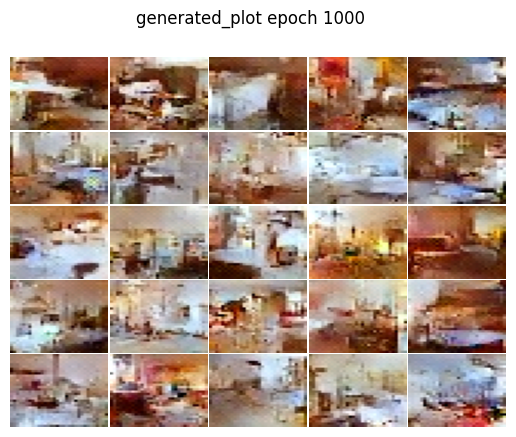

In [224]:
n_row, n_column = 5, 5
n_channels, h, w = realnvp.final_scale.base_input_shape
z_base_sample_shape = [n_row * n_column, n_channels, h, w]
z_base_sample = torch.distributions.Normal(0, 1).sample(sample_shape=z_base_sample_shape)
generated_image_fixed = realnvp.sample(n_row * n_column, z_base_sample=z_base_sample).view(n_row, n_column, 3, 32, 32)
print(generated_image_fixed.shape)
save_plot(n_row=5, n_column=5, generated_image=generated_image_fixed, fixed_image=True, path="./tmp/sample", epoch=1000)

In [20]:
# plotting
n_row, n_column = 5, 5
n_channels, h, w = realnvp.final_scale.base_input_shape
z_base_sample_shape = [n_row * n_column, n_channels, h, w]
z_base_sample = torch.distributions.Normal(0, 1).sample(sample_shape=z_base_sample_shape)

loss_per_epoch = []
for e in range(0, epochs):
    loss_per_bath = []
    epoch_start_time = time.time()
    for i, data in enumerate(dataloader):
        image_batch = data.to(device)
        optimizer.zero_grad()
        z, loss = realnvp(image_batch)
        loss.backward()
        optimizer.step()
        if i % 99 == 0:
            print(f"epcoh {e}, batch {i}, loss {loss}")
        loss_per_bath.append(loss)
    
    epoch_loss = torch.Tensor(loss_per_bath).mean()
    epoch_end_time = time.time()
    print(f"epoch {e}, took: {epoch_end_time - epoch_start_time} loss: {epoch_loss}")
    realnvp.eval()
    
    
    generated_image = realnvp.sample(n_row * n_column, z_base_sample=None).view(n_row, n_column, 3, 32, 32)
    save_plot(n_row=n_row, n_column=n_column, path=sample_path, generated_image=generated_image, epoch=e, fixed_image=False)
    
    generated_image_fixed = realnvp.sample(n_row * n_column, z_base_sample=z_base_sample).view(n_row, n_column, 3, 32, 32)
    save_plot(n_row=n_row, n_column=n_column, path=sample_path, generated_image=generated_image_fixed, epoch=e, fixed_image=True)
    
    realnvp.train()
    
    loss_per_epoch.append(epoch_loss)

epcoh 0, batch 0, loss 24.686450958251953
epcoh 0, batch 99, loss 20.845592498779297
epcoh 0, batch 198, loss 20.163156509399414
epcoh 0, batch 297, loss 19.719894409179688
epcoh 0, batch 396, loss 19.411968231201172
epoch 0, took: 922.2695274353027 loss: 20.220735549926758


AttributeError: 'NoneType' object has no attribute 'to'

In [135]:
from utils import create_deterministic_sample

In [152]:
fixed = create_deterministic_sample(sampling_params=SimpleNamespace(num_samples_nrow=1, num_samples_ncols=1), input_shape=[1, 1, 1])

print(fixed)
print(torch.distributions.Normal(0, 1).sample())

tensor([[[[0.3367]]]])
tensor(0.1288)


In [219]:
checkpoint = torch.load("./model_checkpoints/20230527_044946/best_model.pt")

In [220]:
realnvp.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [176]:
checkpoint["model_state_dict"]["flow_blocks.0.scales.0.batch_normalization_bijector_1.running_mean"].shape

torch.Size([1, 3, 32, 32])

In [216]:
from utils import BatchNormalizationBijector
bn_bj = BatchNormalizationBijector(input_shape=[3, 32, 32], decay=0.)
print(bn_bj.running_mean.shape)

torch.Size([1, 3, 32, 32])


In [217]:
tmp_input = torch.rand(size=[2, 3, 32, 32])
forwarded, _ = bn_bj(tmp_input)
backwarded = bn_bj.reverse(forwarded)

torch.linalg.norm(tmp_input - backwarded)

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])


tensor(2.6112e-07)

In [213]:
bn_bj.running_mean.shape

torch.Size([1, 3, 32, 32])

In [184]:
torch.save({'model_state_dict': bn_bj.state_dict()}, "test.pt")

In [190]:
torch.load("test.pt")["model_state_dict"]["running_mean"].shape

torch.Size([3, 32, 32])